In [ ]:
%matplotlib inline

# Matrix Multiplication from foundations

Assumed foundations are 
- python
- matplotlib
- python standard library
- jupyter notebooks and nbdev

In [ ]:
from nbdev.showdoc import show_doc
from fastcore.all import *

In [ ]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get Data

In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz=path_data/'mnist.pkl.gz'

In [ ]:
from urllib.request import urlretrieve

In [ ]:
# show_doc(urlretrieve)

In [ ]:
if not path_gz.exists(): urlretrieve(MNIST_URL, filename=path_gz)

In [ ]:
!ls -l data

total 16660
-rw-r--r-- 1 msivanes msivanes 17051982 Oct 19 15:12 mnist.pkl.gz


In [ ]:
# show_doc(gzip.open)
# show_doc(pickle.load)

In [ ]:
with gzip.open(path_gz, 'rb') as f: o = pickle.load(f, encoding='latin-1')

In [ ]:
len(o), len(o[0]), len(o[1]), len(o[2])

(3, 2, 2, 2)

In [ ]:
((x_train, y_train), (x_valid, y_valid), _) = o
len(x_train), len(y_train), len(x_valid), len(y_valid)

(50000, 50000, 10000, 10000)

In [ ]:
lst1 = list(x_train[0]); len(lst1)

784

In [ ]:
vals=lst1[200:210];vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

**yield** keyword will convert an expression specified along with it to a generator object and return it to the caller. Hence, to get the values stored inside the generator object, iterate over it.

In [ ]:
# Get the values in chunks using generator
def chunks(x, sz): 
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [ ]:
a=range(10);z=[]
for x in chunks(a, 4):
    z.append(list(x))
test_eq(z, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]])

list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

<matplotlib.image.AxesImage>

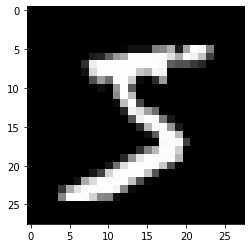

In [ ]:
mpl.rcParams['image.cmap']='gray'
plt.imshow(list(chunks(lst1, 28)))

`itertools.islice` - makes an iterator and returns the selected items from the iterable. Grabs the first n things from the iterable and if we try to grab more, raises a `StopIteration`

The functionality of chunks can be replicated using `itertools.islice`

In [ ]:
from itertools import islice

In [ ]:
it = iter(vals)
islice(it, 5)

<itertools.islice>

In [ ]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [ ]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [ ]:
list(islice(it, 5))

[]

In [ ]:
# the callable is called until the iterator returns the sentinel 
# ie empty list
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

<matplotlib.image.AxesImage>

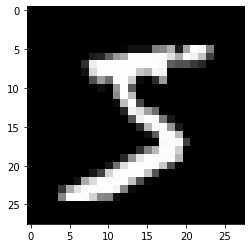

In [ ]:
plt.imshow(img)

## Matrix and tensor

In [ ]:
img[20][15]

0.98828125

We want to instead access pixels in the form of x[i, j] rather than x[i][j]. We are going to implement the magic function `__getitem__` to return the value of object at certain index. Refer [Python Object Model](http://joeyhejna.com/notes/programming/python/1objectmodel/#sources-and-further-reading)

In [ ]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [ ]:
vars(Matrix) # lists all the attributes in an objects `__dict__`

mappingproxy({'__module__': '__main__',
              '__init__': <function __main__.Matrix.__init__(self, xs)>,
              '__getitem__': <function __main__.Matrix.__getitem__(self, idxs)>,
              '__dict__': <attribute '__dict__' of 'Matrix' objects>,
              '__weakref__': <attribute '__weakref__' of 'Matrix' objects>,
              '__doc__': None})

In [ ]:
test_eq(img[20][15], 0.98828125)

m = Matrix(img)
test_eq(m[20, 15], 0.98828125)

In [ ]:
# Both are equivalent
# getattr(m, 'xs')
# m.xs

[Tensor](https://pytorch.org/docs/stable/tensors.html) - A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

In [ ]:
import torch
from torch import tensor

In [ ]:
tensor([1, 2, 3])

tensor([1, 2, 3])

In [ ]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))

In [ ]:
test_eq(x_train.shape, torch.Size([50000, 784]))
test_eq(x_train.type(), 'torch.FloatTensor')

In [ ]:
imgs = x_train.reshape((-1, 28, 28))
test_eq(imgs.shape, torch.Size([50000, 28, 28]))

<matplotlib.image.AxesImage>

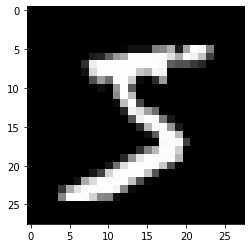

In [ ]:
plt.imshow(imgs[0])

In [ ]:
imgs[0, 20, 15]

tensor(0.9883)

In [ ]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [ ]:
test_eq(min(y_train), tensor(0))
test_eq(max(y_train), tensor(9))

test_eq(y_train.min(), tensor(0))
test_eq(y_train.max(), tensor(9))

## Random numbers

[Wichmann Hill algorithm](https://en.wikipedia.org/wiki/Wichmann%E2%80%93Hill) used before Python 2.3

In [ ]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [ ]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [ ]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [ ]:
rand(), rand(), rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [ ]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [ ]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.1643])
In child: tensor([0.1643])


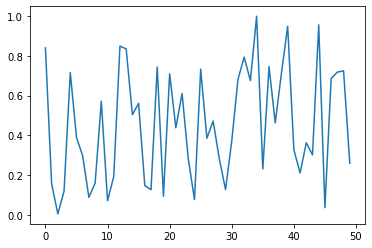

In [ ]:
plt.plot([rand() for _ in range(50)]);

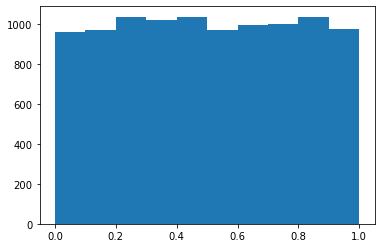

In [ ]:
plt.hist([rand() for _ in range(10000)]);

In [ ]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

3.83 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 torch.randn(784, 10)

72.1 µs ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix Multiplication

In [ ]:
torch.manual_seed(1)
weights = torch.randn(784, 10) # random num with a normal distrib (mean 0 & std 1)
bias = torch.zeros(10)

In [ ]:
m1 = x_valid[:5]
m2 = weights

In [ ]:
test_eq(m1.shape, torch.Size([5, 784]))
test_eq(m2.shape, torch.Size([784, 10]))

In [ ]:
ar, ac = m1.shape #n_rows, n_cols
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

In [ ]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [ ]:
for i in range(ar):     # 5
    for j in range(bc): # 10
        for k in range(ac): # 784
            t1[i, j] += m1[i, k] * m2[k, j]

In [ ]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [ ]:
test_eq(t1.shape, torch.Size([5, 10]))

In [ ]:
import numpy as np
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
np.set_printoptions(precision=2, linewidth=140)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):     # 5
        for j in range(bc): # 10
            for k in range(ac): c[i, j] += a[i, k] * b[k, j]
    return c

In [ ]:
%time _=matmul(m1, m2)

CPU times: user 490 ms, sys: 15 µs, total: 490 ms
Wall time: 492 ms


## Numba

Compile the code into machine code. Works with numpy alone. With numba, make python run at C speed.

In [ ]:
from numba import njit
from numpy import array

In [ ]:
def dot(a,b): # dot product of two vectors
    res=0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [ ]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 16 µs, sys: 6 µs, total: 22 µs
Wall time: 25.5 µs


20.0

In [ ]:
@njit
def dot(a,b):
    res=0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [ ]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 286 ms, sys: 14.1 ms, total: 300 ms
Wall time: 301 ms


20.0

The second time you run it, see the performance improvement.

In [ ]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 22.2 µs


20.0

Now only two of our loops are running in python, not three

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):     # 5
        for j in range(bc): c[i, j] += dot(a[i,:], b[:,j])
    return c

In [ ]:
m1a,m2a = m1.numpy(),m2.numpy()

In [ ]:
from fastcore.test import *
test_close(t1,matmul(m1a,m2a))

In [ ]:
%timeit -n 50 matmul(m1a,m2a)

770 µs ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise ops

In [ ]:
a = tensor([10., 6., -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [ ]:
a + b

tensor([12., 14.,  3.])

In [ ]:
(a < b).float().mean()

tensor(0.67)

In [ ]:
m = tensor([[1., 2, 3], [4, 5, 6], [7,8,9]]);m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius Norm

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [ ]:
sf=(m*m).sum();sf

tensor(285.)

In [ ]:
sf.sqrt()

tensor(16.88)

Norm is same as abs val for the scalar.

In [ ]:
m[2, :] # row 2 all cols

tensor([7., 8., 9.])

In [ ]:
m[:, 2] # all row col 2

tensor([3., 6., 9.])

for tensors of higher rank than 1 such matrix, any trailing colons are optional

In [ ]:
m[2], m[2, :]

(tensor([7., 8., 9.]), tensor([7., 8., 9.]))

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):     # 5
        for j in range(bc): c[i, j] = (a[i,:] * b[:,j]).sum()
    return c

In [ ]:
test_close(t1, matmul(m1,m2))

In [ ]:
%timeit -n 50 _=matmul(m1,m2)

834 µs ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):     # 5
        for j in range(bc): c[i, j] = torch.dot(a[i,:],b[:,j])
    return c

In [ ]:
test_close(t1,matmul(m1,m2))

In [ ]:
%timeit -n 50 _=matmul(m1,m2)

606 µs ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

broadcasting -> how arrays with different shapes are treated during arthmetic operations

smaller array is "broadcast" across the larger arrays so that they have compatible shapes. It provides a means of vectorizing array operations so that looping occurs in C instead of Python. It does this without making unnecessary copies of data and usually leads to efficient algorithm

*See [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [ ]:
a

tensor([10.,  6., -4.])

In [ ]:
a > 0

tensor([ True,  True, False])

Here 0 is being **broadcast** to have the same dimension as a.

Eg: Normalize our dataset by subtracting the mean (scalar) from the entire dataset (matrix) & dividing by the standar deviation(another scalar) using broadcasting.

More examples

In [ ]:
a + 1

tensor([11.,  7., -3.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

In [ ]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [ ]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
t = c.expand_as(m) # Expand this tensor to the same size as :attr:`other`.

In [ ]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

We don't really copy the rows, but it looks as if we did. In fact, rows are given a stride of 0

In [ ]:
t.storage() # returns underlying storage

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [ ]:
t.stride(), t.shape # stays at the same place when move to the next row

((0, 1), torch.Size([3, 3]))

In [ ]:
c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [ ]:
c.unsqueeze(0), c.unsqueeze(0).shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [ ]:
c.unsqueeze(0), c[None,:] #inserts a new unit axis in the dimension 0

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [ ]:
c.unsqueeze(1), c[:,None] #inserts a new unit axis in the dimension 1

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [ ]:
c[None].shape, c[...,None].shape # 2nd forms inserts a unit axis at the end

(torch.Size([1, 3]), torch.Size([3, 1]))

We can skip trailing `:`s. And `...` means 'all preceding dimensions'.

In [ ]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [ ]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [ ]:
c[None,:]

tensor([[10., 20., 30.]])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [ ]:
c[None,:], c[None,:].shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [ ]:
c[:,None], c[:,None].shape

(tensor([[10.],
         [20.],
         [30.]]),
 torch.Size([3, 1]))

In [ ]:
c[None,:] * c[:,None] # 3 rows and 3 cols

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [ ]:
c[None] > c[:,None] # 3 rows and 3 cols

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [ ]:
m * m

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

When operating on two arrays/tensors, Numpy/Pytorch compares theirs shapes element-wise. It starts with **trailing dimensions** and work its way forward. Two dimensions are compatible when
* they are equal
* one of them is 1, in which case that dimension is broadcasted to make it the same size

[Numpy Documention on broadcasting rules](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules)

```
1 x 3
3 x 1
= 3 x 3
```
```
A      (4d array):  8 x 1 x 6 x 1
B      (3d array):      7 x 1 x 5
Result (4d array):  8 x 7 x 6 x 5
```

Example shapes that do not match
```
A      (1d array):  3
B      (1d array):  4 # trailing dimensions do not match

A      (2d array):      2 x 1
B      (3d array):  8 x 4 x 3 # second from last dimensions mismatched
```

## Matmul with broadcasting

Let's grab a single digit.

In [ ]:
digit = m1[0]

In [ ]:
digit.shape, m2.shape  # 784 long vector, weight matrix 

(torch.Size([784]), torch.Size([784, 10]))

In [ ]:
digit[:,None].shape

torch.Size([784, 1])

In [ ]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

In [ ]:
(digit[:,None]*m2).shape # broadcast version

torch.Size([784, 10])

In [ ]:
def matmul(a,b):
    #print(a.shape)
    #print(b.shape)
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): # iterate for 5 times
        # for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum() # previous version
            c[i] = (a[i,:,None] * b).sum(dim=0) # broadcast version
            #print(c[i].shape)
    return c

In [ ]:
o = matmul(m1,m2);o.shape

torch.Size([5, 10])

In [ ]:
test_close(t1,matmul(m1,m2))

In [ ]:
%timeit -n 50 _=matmul(m1,m2)

170 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


We can now use the whole dataset

In [ ]:
tr=matmul(x_train,weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [ ]:
tr.shape

torch.Size([50000, 10])

In [ ]:
%timeit -n 5 _=matmul(x_train,weights)

1.33 s ± 65 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) is a compact representation for combining products and sums in a general way. The key rules are
- Repeating letters between the input arrays means that values along those axes will be multiplied together
- Omitting a letter from the output means that values along that axies will be summed.

In [ ]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
#c[i,j] += a[i,k] * b[k,j]
#c[i,j] = (a[i,:] * b[:,j]).sum()
mr=torch.einsum('ik,kj->ikj',m1,m2)
mr.shape

torch.Size([5, 784, 10])

In [ ]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
torch.einsum('ik,kj->ij',m1,m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
def matmul(a,b): return torch.einsum('ik,kj->ij',a,b)

In [ ]:
test_close(tr,matmul(x_train,weights), eps=1e-3)

In [ ]:
%timeit -n 5 _=matmul(x_train,weights)

12.7 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch op

We can use pytorch function or operator directly for matrix multiplication

In [ ]:
test_close(tr, x_train@weights, eps=1e-3)

In [ ]:
%timeit -n 5 _=torch.matmul(x_train,weights)

14.4 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [ ]:
def matmul(grid,a,b,c):
    i,j = grid
    if i<c.shape[0] and j<c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i,k] * b[k,j]
        c[i,j] = tmp

In [ ]:
res=torch.zeros(ar,bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

In [ ]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [ ]:
res = torch.zeros((ar,bc))
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
from numba import cuda # cuda programming model

In [ ]:
def matmul(grid,a,b,c):
    i,j = grid
    if i<c.shape[0] and j<c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i,k] * b[k,j]
        c[i,j] = tmp

GPU required. Only works on nvidia

In [ ]:
@cuda.jit
def matmul(grid,a,b,c):
    i,j = cuda.grid(2)
    if i<c.shape[0] and j<c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i,k] * b[k,j]
        c[i,j] = tmp

In [ ]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))

TPM - Threads per blocks

In [ ]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

In [ ]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg) # launch kernel on gpu
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [ ]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

In [ ]:
m1c,m2c = x_train.cuda(),weights.cuda() # copies over to the gpu

In [ ]:
r=(m1c@m2c).cpu() # copies it back to the host

In [ ]:
%timeit -n 10 r=(m1c@m2c).cpu()